# Arima Model and Exponential Smoothing

For this exercise we will be using Pandas, Numpy, Matplotlib and Statsmodels libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

The dataset we will use is the Housing price in Dublin from January 2018 to May 2022.

In [2]:
ds_path = "./DataSets/House Sales Dublin.csv"

In the Next cell we defined a function to help Pandas parse the date into the correct format

In [3]:
def parser(x):
    return pd.datetime.strptime(x, '%d/%m/%Y')

We are only using the date and price column for this exercise,
In the next cell we will select this two columns and also rename them.

In [4]:
data_set = pd.read_csv(ds_path, dtype={'Property Size Description': 'str'}, date_parser=parser, parse_dates=['Date of Sale (dd/mm/yyyy)'])

selected_data = data_set[['Date of Sale (dd/mm/yyyy)', 'Price (€)']]
series = selected_data.copy()

series.rename(columns = {'Date of Sale (dd/mm/yyyy)':'Date', 'Price (€)':'Price'}, inplace = True)
series.head()

/tmp/ipykernel_492354/1323472867.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x, '%d/%m/%Y')


,Date,Price
0,2017-12-31,710000.00
1,2018-01-02,627230.70
2,2018-01-02,1130000.00
3,2018-01-02,277000.00
4,2018-01-02,348017.62


As we have multiples houses sold in the same day, we will resample our data for a weekly average

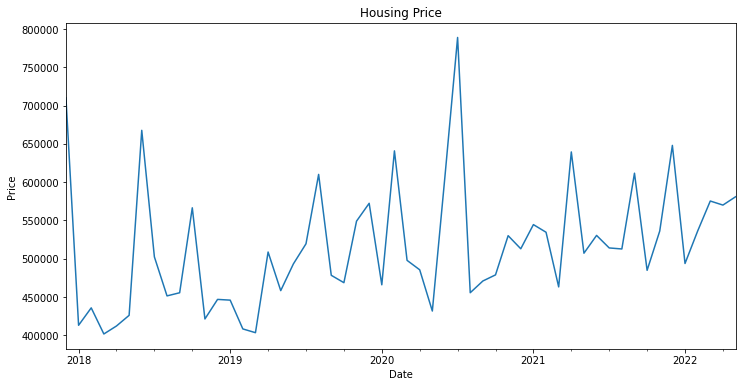

In [5]:
df = series.resample(rule='M', kind='period', origin='start_day', on='Date').mean()

fig, ax = plt.subplots(figsize=(12, 6))
df.Price.plot()
plt.title('Housing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Checking Stationarity

We need will now analise if our dataset is stationary or not.

#### Data is considered stationary when its statistical properties don't change over time.

Next we will divide our data in 4 groups and check if the Mean and Variance change over time.

In [6]:
X = df.values
split = int(len(X) / 4)
prices = [X[0:split], X[split:(split*2)], X[(split*2):(split*3)], X[(split*3):]]
mean = [i.mean() for i in prices]
var = [i.var() for i in prices]
print('GROUP','MEAN', sep='\t', end='\t\t')
print('VARIANCE')
for i in range(len(prices)):
    print(f'{i+1}{mean[i]:{16}.2f} {var[i]:{20}.2f}')

GROUP	MEAN		VARIANCE
1       485478.93        9360463126.97
2       490967.30        3398907418.28
3       536976.89        8426044102.57
4       546965.87        2897399647.19


We can see that the Mean is varying around the 50's, the variance had a more drastic change on the second group, but it still dosen't look like the data is changing over time.

To confirm that this data is stationary we will use The Augmented Dickey-Fuller (ADF), a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.
* The null hypothesis of the test is that the data is not stationary.
* The alternate hypothesis is that the data is stationary.

We interpret this result using the p-value from the test.
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [7]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value:.2f}')

ADF Statistic: -7.029381
p-value: 0.000000
Critical Values:
1%: -3.56
5%: -2.92
10%: -2.60


Looking at the p-value we can reject the null hypotesis, the results of the test statistic value of -7 is also a indicator that the data is stationary.
The more negative this statistic, the more likely we have a stationary dataset.

If we look at the critical values and compare it to our ADF statistic value, we can see that -7 is less than the value of -3.56 at 1%, meaning that we can reject the null hypothesis with a confidence level of 99%

Finally let's have a look at our Autocorrelation plot

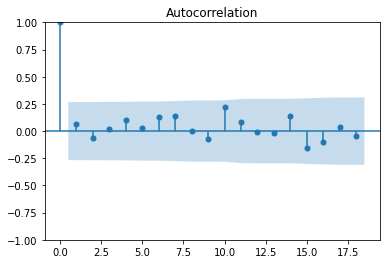

In [8]:
plot_acf(df)
plt.show()

Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

As we can see apart from the 1st lag we don't have any spikes above the blue region, meaning there are no correlations between the lags

## Simple Exponential Smoothing

We use simple exponential smoothing for irregular data with few points, no seasonality or trend.

A simple exponential smoothing line is basically a moving average that considers all the points behind the current point but gives a rather higher weight to the more recent data. 

It requires a single parameter, alpha (a), also known as the smoothing factor or coefficient.

Alpha is a value between 0 and 1 that defines the weighting of the calculation.
* Recent observations greatly influence the model when alpha is closer to 1.
* Historical observations greatly influence the model when alpha is closer to 0.

/home/kelly/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


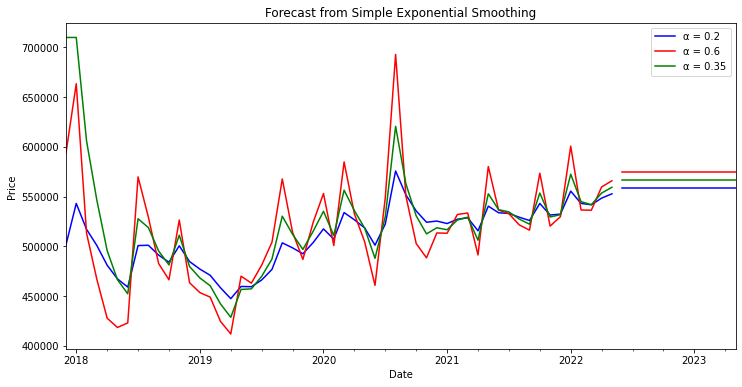

In [9]:
# Simple Exponential Smoothing

fig, ax = plt.subplots(figsize=(12, 6))

# Fit Model α = 0.2
fit1 = SimpleExpSmoothing(df).fit(smoothing_level=0.2)
# Forecast
fcast1 = fit1.forecast(12).rename('α = 0.2')

# plot α = 0.2
fcast1.plot(color='blue', legend=True)
fit1.fittedvalues.plot(color='blue')

# Fit Model α = 0.6
fit2 = SimpleExpSmoothing(df).fit(smoothing_level=0.6)
# Forecast
fcast2 = fit2.forecast(12).rename('α = 0.6')

# plot α = 0.6
fcast2.plot(color='red', legend=True)
fit2.fittedvalues.plot(color='red')

# Fit Model default α
fit3 = SimpleExpSmoothing(df).fit()
# Forecast
fcast3 = fit3.forecast(12).rename(f"α = {fit3.model.params['smoothing_level']:.2f}")

# plot default α
fcast3.plot(color='green', legend=True)
fit3.fittedvalues.plot(color='green')

plt.title('Forecast from Simple Exponential Smoothing')
plt.ylabel('Price')
plt.show()

## ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The parameters of the ARIMA model are:

* p (AR): The number of lag observations included in the model, also called the lag order.
* d (I): The number of times that the raw observations are differenced, also called the degree of differencing.
* q (MA): The size of the moving average window, also called the order of moving average.

We will use the retail sales data for this exercise


In [10]:
retail_ds_path = "./DataSets/Retail Sales.csv"

Bellow we will look at how the data looks like

In [11]:
def retail_parser(x):
    return pd.datetime.strptime(x, '%m/%Y')

retail_sales = pd.read_csv(retail_ds_path, header=0, parse_dates=[0], index_col=0, date_parser=retail_parser)
retail_sales.head()

/tmp/ipykernel_492354/702821728.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x, '%m/%Y')


,Sales
Date,
2019-01-01,266.0
2019-02-01,145.9
2019-03-01,183.1
2019-04-01,119.3
2019-05-01,180.3


And we will plot this data into a graph

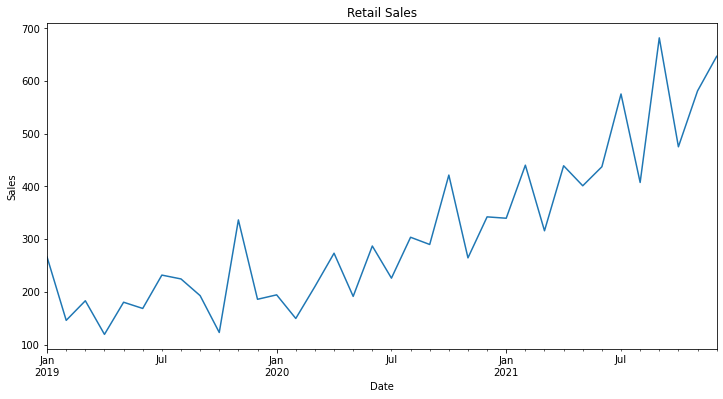

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

retail_sales.Sales.plot()
plt.title('Retail Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Checking Stationarity

From the graph above we can see that that the data has a clear upward trend, and that is a sign that this data might not be stationary, so let's confirm it.

We will once again do the ADF test

In [13]:
result = adfuller(retail_sales.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value:.2f}')

ADF Statistic: 3.060142
p-value: 1.000000
Critical Values:
1%: -3.72
5%: -2.99
10%: -2.63


And we now can confirm that this data is not stationary.

## Autocorrelation plot

Let’s also take a quick look at an autocorrelation plot of the time series

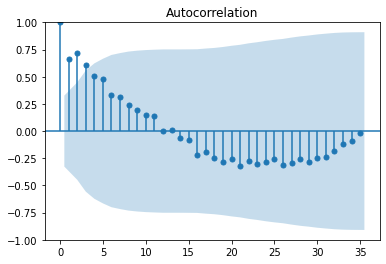

In [14]:
plot_acf(retail_sales, lags=35)
plt.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.